# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has leaned on another dataset and applying to our own problem

* Pretrained model = foundation model

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.7.1
0.22.1


Let's import the code we've writte in previous sections so that we don't have to write it all again

In [2]:
from src.engine import train
from src.setup_data import *

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)

device

'mps'

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on

In [4]:
# Setup directory path
from pathlib import Path
image_path = Path("data") / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it inot PyTorch DataLoaders

To do so, we can use `setup_data.py` and the `create_dataloaders()` functions we've already created

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use

Important point: when using a pretrained model, it's important that the data (including custom data) that you pass through it is **transformed** in the same way that the data the model was trained on

In [5]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir.__str__(),
    test_dir=test_dir.__str__(),
    transform=None,
    batch_size=32,
    num_workers=1
)

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`

In [6]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # resize image to 224 x 224
    transforms.ToTensor(), # get images into range [0, 1]
    normalize, # make sure images have the same distribution as ImageNey
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [7]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir.__str__(),
    test_dir=test_dir.__str__(),
    transform=manual_transforms,
    batch_size=32,
    num_workers=1,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x117177610>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on pretrained model weights you're using

In [8]:
# Get a set of pretrained model weight
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir.__str__(),
    test_dir=test_dir.__str__(),
    transform=auto_transforms,
    batch_size=32,
    num_workers=1,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x117224050>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. PapersWithCode (for models across different problem spaces / domains)

### 3.1 Which pretrained model should I use

*Experiment, experiment, experiment*

The whole idea of transfer learning: tak an already well-performing model from a problem space similar to your onw and then customize to your own problem

Three things to consider:
1. Speed - how fast does it run
2. Size - how big is the model
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images?)

Where does the model live?

* Is it on device? (like a self-driving car)
* Does it live on a server?

Looking at: https://docs.pytorch.org/vision/main/models.html

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size


However, in light of The Bitter Lesson, if we had infinite computer, we'd likely pick the biggest model + most parameters  + most general we could

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0

In [11]:
# Old method of creating a pratrained model
model = torchvision.models.efficientnet_b0(pretrained=True)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# New method of creating a prtrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

In [13]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [15]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [17]:
# Print with torchinfo
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 3, 224, 224), # example of [batch_size, color_channel, heigth, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model typically you'll freeze the base layers of a pretrained/foundation model and update the output layrs to suit your own problem

In [19]:
# Freeze all of the base layer in EffNetB0
for param in model.parameters():
    # print(param)
    param.requires_grad = False

In [21]:
# Update the classifier head of our model to suit our problem
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [24]:
torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280, 
        out_features=len(class_names), 
        bias=True
    ),
)

model = model.to(device)

In [25]:
summary(
    model=model,
    input_size=(1, 3, 224, 224), # example of [batch_size, color_channel, heigth, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [26]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

In [41]:
# Import train function
from src import engine

# Set the manual seed
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device="cpu",
)

# End timer and print out how long it took
end_time = timer()
print(f"[INOF] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 0.5227 | train_acc: 0.9180 | test_loss: 0.5841 | test_acc: 0.8352
Epoch: 2 | train_loss: 0.5692 | train_acc: 0.7891 | test_loss: 0.5903 | test_acc: 0.7955
Epoch: 3 | train_loss: 0.4873 | train_acc: 0.9375 | test_loss: 0.5070 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.4796 | train_acc: 0.7852 | test_loss: 0.4295 | test_acc: 0.9271
Epoch: 5 | train_loss: 0.4939 | train_acc: 0.7773 | test_loss: 0.4764 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.4592 | train_acc: 0.8320 | test_loss: 0.4628 | test_acc: 0.8456
Epoch: 7 | train_loss: 0.4365 | train_acc: 0.8125 | test_loss: 0.4154 | test_acc: 0.8655
Epoch: 8 | train_loss: 0.4680 | train_acc: 0.8320 | test_loss: 0.3794 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.3846 | train_acc: 0.9375 | test_loss: 0.3675 | test_acc: 0.8958
Epoch: 10 | train_loss: 0.4491 | train_acc: 0.8164 | test_loss: 0.4235 | test_acc: 0.8968
[INOF] Total training time: 533.541 seconds


In [42]:
results

{'train_loss': [0.5227379649877548,
  0.5691727474331856,
  0.48729588463902473,
  0.4796094335615635,
  0.4939267411828041,
  0.4592384584248066,
  0.4364832788705826,
  0.46798611991107464,
  0.38455862179398537,
  0.4491236247122288],
 'train_acc': [0.91796875,
  0.7890625,
  0.9375,
  0.78515625,
  0.77734375,
  0.83203125,
  0.8125,
  0.83203125,
  0.9375,
  0.81640625],
 'test_loss': [0.5841261347134908,
  0.5903285543123881,
  0.5069917937119802,
  0.4295256733894348,
  0.4764011899630229,
  0.4628115693728129,
  0.4154206116994222,
  0.37940434614817303,
  0.36751875778039295,
  0.4234750270843506],
 'test_acc': [0.8352272727272728,
  0.7954545454545454,
  0.8863636363636364,
  0.9270833333333334,
  0.8664772727272728,
  0.8456439393939394,
  0.8655303030303031,
  0.8664772727272728,
  0.8958333333333334,
  0.8967803030303031]}

## 5. Evaluate model by plotting loss curves

In [43]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    # plt.ylim([0, 1.2])
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    # plt.ylim([0, 1])
    plt.legend()

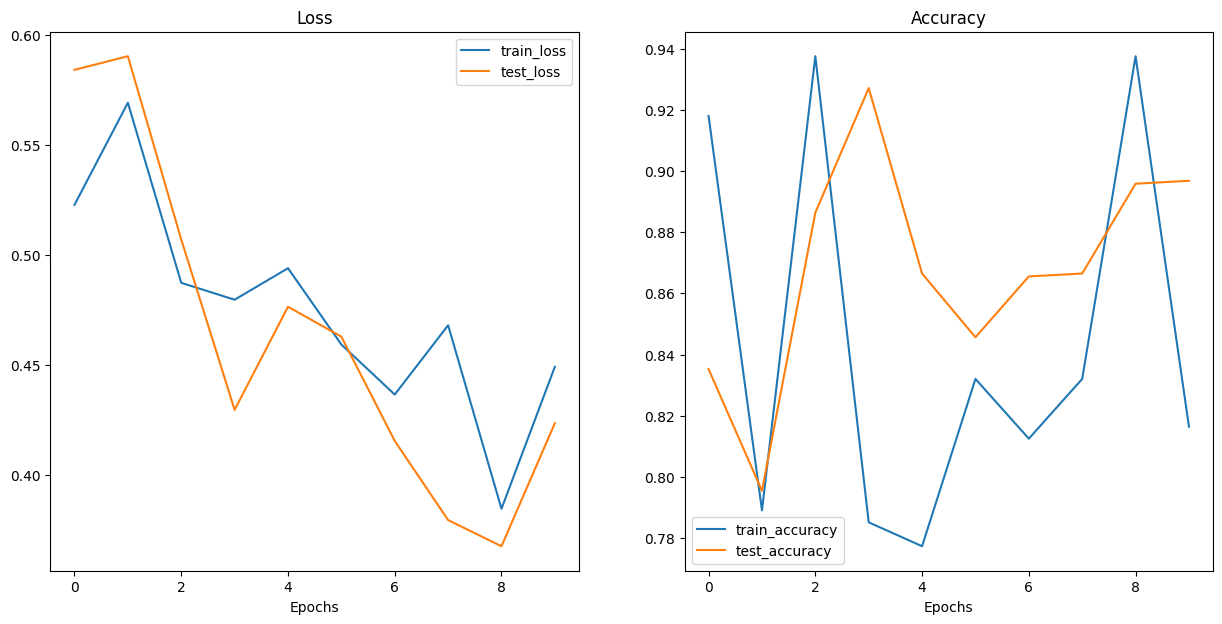

In [44]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data exploere's motto of *visualize, visualize, visualize*

And make some qualitative predictions on our test set

Some things to keep in mind when making predictions/inference on test data/custom data

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same dvice as our model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom datat the sam

To do all of this automagically, let's create function called `pred_and_plot_image()`

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open th eimage with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to predict probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction proability from step 9

In [64]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model...
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    transform,
    image_size: Tuple[int, int] = (224, 224),
    device: str = device
):
    # 2. Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if one doesn't exist...
    if transforms is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])
        
    # Predicto on image
    # 4. Make sure the model is on the target device...
    model.to(device)
    
    # 5. Turn on inference mode and eval mode...
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension...
        transformed_image = image_transform(img).unsqueeze(dim=0)
        
        # 7. Make a prediction on the transformed image...
        target_image_pred = model(transformed_image.to(device))
    
    # 8. Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # 9. Convert the model's pred probs to pred labels
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)
    
    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}%")
    plt.axis(False)
    
    

In [65]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

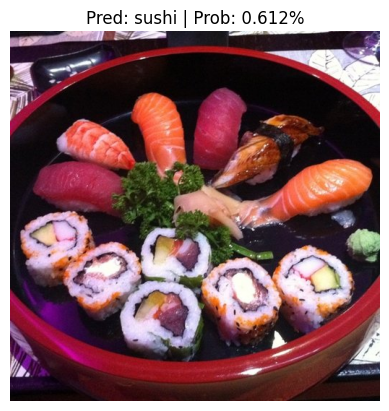

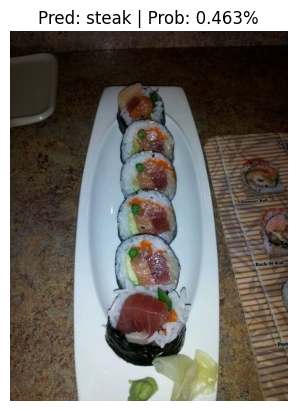

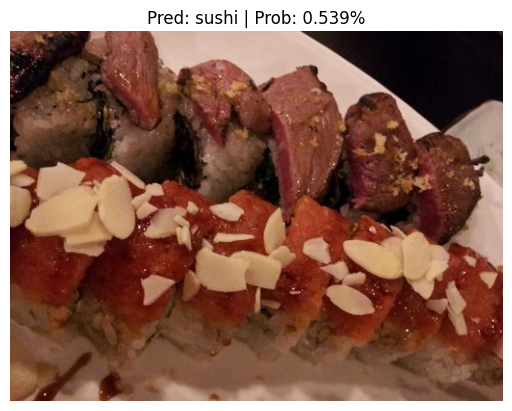

In [71]:
# Get a random list of image paths from the test set
import random
from pathlib import Path

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=model,
        image_path=image_path,
        class_names=class_names,
        transform=auto_transforms,
    )

### 6.1 Making prediction on a custom image

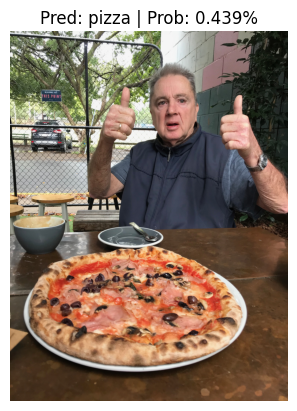

In [72]:
pred_and_plot_image(
    model=model,
    image_path="pizza-dad.jpeg",
    class_names=class_names,
    transform=auto_transforms,
)